In [1]:
import pandas as pd
import math as m
from scipy import stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import  metrics
from itertools import product
%pylab inline

/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/home/vladimir/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load data

In [2]:
data = pd.read_csv("cleaned_unemployment.csv", index_col=['Unnamed: 0'])
GDP = pd.read_csv("cleaned_GDP.csv", index_col=['Unnamed: 0'])

In [3]:
data = pd.concat([data , GDP], axis = 1)

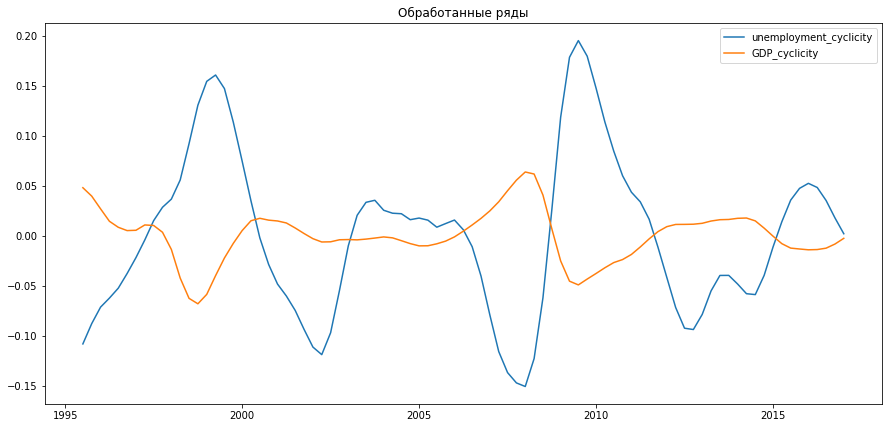

In [7]:
plt.figure(figsize(15,7))
plt.plot(data.index.values, data.unemployment_cyclicity.values, label="unemployment_cyclicity")
plt.plot(data.index.values, data.GDP_cyclicity.values, label="GDP_cyclicity")
plt.title("Обработанные ряды")
plt.legend()

## Create new feature

### lags

In [8]:
def time_series_to_DataFrame(data, lags, target):
    lags = list(map(lambda x: x+1, lags))
    #Готовим название колонок
    columns = []
    for i in range(len(data.columns)):
        #print (i , lags[i])
        for j in range(1, lags[i]):
            #print ('i = ', i,'j = ',j)
            #print (columns)
            columns.append(data.columns[i] + '_lag_' + str(j))
    columns.append(target)
    #готовим target
    target = pd.DataFrame(data[target].values[max(lags)-1:])
    #готовим индексы
    index = data.index
    
    
    data = data.values
    
    new_data = []
    for i in range(max(lags)-1,len(data)):
        res = []
        for lag in range(len(lags)):
            for j in range(1,lags[lag]):
                res.append(data[i-j][lag])
        new_data.append(res)
    
    
    new_data = pd.DataFrame(new_data)
    new_data = pd.concat([new_data, target], axis = 1)
    new_data.columns = columns
    new_data.index = index[max(lags)-1:]
    return new_data

### Percent_change

In [9]:
def percent_change(data, lag, target, percent = None):
    lag += 1
    new_data = []
    new_DataFrame = pd.DataFrame()
    new_DataFrame[target] = data[target].values[lag:]
    new_DataFrame.index = data.index[lag:]
    for i in range( lag ,len(data)):
        res = []
        for j in range(1,lag):
            if percent == True:
                res.append(data[target].values[i-j]/data[target].values[i-j-1] * 100 - 100)
            else:
                res.append(data[target].values[i-j]/data[target].values[i-j-1])
        new_data.append(res)
    import numpy as np
    new_data = np.array(new_data)
    new_data = new_data.transpose()
    for i in range(1, lag):
        new_DataFrame[target + '_percent_change_' + str(i)] = new_data[i-1]
    new_DataFrame.drop(target, axis = 1, inplace=True)
    return new_DataFrame

In [10]:
def percent_change_DataFrame(data, list_of_percent_change, percent = None):
    shape = []
    for i in list_of_percent_change:
        shape.append(i[1])
    shape = max(shape)
    shape = len(data) - shape - 1
    
    data_percent_change = pd.DataFrame()
    data_percent_change[data.columns[0]] = data[data.columns[0]].values[-shape:]#Временно
    data_percent_change.index = data.index.values[-shape:]
    
    for i in list_of_percent_change:
        DataFrame = percent_change(data, i[1], i[0], percent)
        data_percent_change = pd.concat([data_percent_change, DataFrame[-shape:]], axis = 1 )
    data_percent_change.drop(data.columns[0], axis = 1, inplace=True)#удаляем эту хрень
    return data_percent_change

### moving_average

In [11]:
def moving_average(data, lag, target):
    averege = []
    new_DataFrame = pd.DataFrame()
    for i in range(lag,len(data[target])):
        sum_ = 0
        for j in range(1, lag + 1):
            sum_ += data[target].values[i - j]
        averege.append(sum_/(lag))
    new_DataFrame[target + '_averege_' + str(lag)] = averege
    new_DataFrame.index = data.index.values[lag:]
    return new_DataFrame

In [12]:
def moving_average_DataFrame(data, list_of_moving_average):
    shape = []
    for i in list_of_moving_average:
        shape.append(i[1])
    shape = max(shape)
    shape = len(data) - shape
    
    data_moving_average = pd.DataFrame()
    data_moving_average[data.columns[0]] = data[data.columns[0]].values[-shape:]
    data_moving_average.index = data.index.values[-shape:]
    
    for i in list_of_moving_average:
        DataFrame = moving_average(data, i[1], i[0])
        data_moving_average = pd.concat([data_moving_average, DataFrame[-shape:]], axis = 1 )
    data_moving_average.drop(data.columns[0], axis = 1, inplace=True)
    return data_moving_average

### moving_average_geom

In [13]:
def moving_average_geom(data, lag, target, percent = None):
    lag += 1
    
    new_data = []
    for i in range( lag ,len(data)):
        res = 1
        for j in range(1,lag):
            res *= (data[target].values[i-j]/data[target].values[i-j-1])
        res = res ** (1/(lag - 1))
        if percent == True:
            res = res *100 - 100
        new_data.append(res)
    
    new_DataFrame = pd.DataFrame()
    new_DataFrame[target + 'average_geom' + str(lag-1)] = new_data
    new_DataFrame.index = data.index.values[lag:]
    
    return new_DataFrame

## Additional functions

In [14]:
#Для удобства работы, таргет последняя колонка
def target_to_end(data, target):
    col_target = data[target]
    data.drop(target, axis = 1, inplace=True)
    data[target] = col_target
    return data

In [15]:
#на вход подается данные и список столбцов, которые надо отмаштобировать
def scaling_for_DataFrame(X_train, X_test, columns_to_scaling):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train[columns_to_scaling])
    
    X_train_1 = scaler.transform(X_train[columns_to_scaling])
    X_test_1 = scaler.transform( X_test[columns_to_scaling])
    
    X_train_1 = np.array(X_train_1)
    X_test_1 = np.array(X_test_1)
    
    X_train_1 = X_train_1.transpose()
    X_test_1 = X_test_1.transpose()
    
    for i in range(len(X_train_1)):
        X_train[columns_to_scaling[i]] = X_train_1[i]
        X_test[columns_to_scaling[i]] = X_test_1[i]
    return X_train, X_test

In [16]:
#соединяем DataFrame
def concat_DataFrame(list_of_DataFtame, axis):
    import pandas as pd
    shape = []
    for i in list_of_DataFtame:
        shape.append(len(i))
    shape = min(shape)
    list_of_DataFtame = map(lambda x: x.iloc[-shape:], list_of_DataFtame)
    ready_data = pd.concat(list_of_DataFtame, axis = axis)
    return ready_data

# Создадим DataFrame, готовый к обучению

In [17]:
data.columns

Index(['unemployment_cyclicity', 'GDP_cyclicity'], dtype='object')

In [18]:
#лаги
lags = [5,5]
lag_data = time_series_to_DataFrame(data, lags, 'unemployment_cyclicity')
lag_data.drop('unemployment_cyclicity', axis =  1, inplace= True)

#процентные изменения
percent_change_data = percent_change_DataFrame(data, [['unemployment_cyclicity', 2], ['GDP_cyclicity', 2]], True)

#Скользящие среднее
moving_average_data = moving_average_DataFrame(data,  [['unemployment_cyclicity', 3], 
                                                      ['GDP_cyclicity', 3]] )

#скользящие среднее геометрическое
#moving_average_geom_data = moving_average_geom(data, 3, "unemployment_cyclicity", True)



#Выделим те , которые надо отмаштобировать
columns_for_scaling = []# их надо будет отмаштобировать
for i in lag_data.columns:
    columns_for_scaling.append(i)# лаги
for i in moving_average_data.columns:
    columns_for_scaling.append(i)#скользящие среднии
for i in percent_change_data.columns:
    columns_for_scaling.append(i)#процентные изменения

#Соединяем все данные
ready_data = data[['unemployment_cyclicity']]
list_of_DataFtame = [ready_data, lag_data, percent_change_data, moving_average_data ]
ready_data = concat_DataFrame(list_of_DataFtame, 1)

In [19]:
ready_data.to_csv("ready_data")

### Разделим данные на 2 части: обучение-валидацию и тест

In [20]:
data_train = ready_data.iloc[:-12]
data_test = ready_data.iloc[-12:]

In [21]:
data_test

,unemployment_cyclicity,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3,GDP_cyclicity_lag_4,GDP_cyclicity_lag_5,unemployment_cyclicity_percent_change_1,unemployment_cyclicity_percent_change_2,GDP_cyclicity_percent_change_1,GDP_cyclicity_percent_change_2,unemployment_cyclicity_averege_3,GDP_cyclicity_averege_3
2014.25,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.016110,0.014794,0.012520,21.803266,-0.166774,7.021537,1.561142,-0.042441,0.016661
2014.50,-0.058753,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,0.017804,0.017511,0.016362,0.016110,0.014794,20.117642,21.803266,1.673657,7.021537,-0.048523,0.017225
2014.75,-0.039524,-0.058753,-0.057857,-0.048167,-0.039545,-0.039611,0.014936,0.017804,0.017511,0.016362,0.016110,1.547497,20.117642,-16.108424,1.673657,-0.054926,0.016750
2015.00,-0.011284,-0.039524,-0.058753,-0.057857,-0.048167,-0.039545,0.007688,0.014936,0.017804,0.017511,0.016362,-32.727788,1.547497,-48.527638,-16.108424,-0.052045,0.013476
2015.25,0.014097,-0.011284,-0.039524,-0.058753,-0.057857,-0.048167,-0.000313,0.007688,0.014936,0.017804,0.017511,-71.449399,-32.727788,-104.076617,-48.527638,-0.036520,0.007437
2015.50,0.035704,0.014097,-0.011284,-0.039524,-0.058753,-0.057857,-0.007839,-0.000313,0.007688,0.014936,0.017804,-224.922146,-71.449399,2401.094425,-104.076617,-0.012237,-0.000155
2015.75,0.047457,0.035704,0.014097,-0.011284,-0.039524,-0.058753,-0.012278,-0.007839,-0.000313,0.007688,0.014936,153.280719,-224.922146,56.639141,2401.094425,0.012839,-0.006810
2016.00,0.052475,0.047457,0.035704,0.014097,-0.011284,-0.039524,-0.013162,-0.012278,-0.007839,-0.000313,0.007688,32.916271,153.280719,7.195095,56.639141,0.032419,-0.011093
2016.25,0.048324,0.052475,0.047457,0.035704,0.014097,-0.011284,-0.013968,-0.013162,-0.012278,-0.007839,-0.000313,10.574557,32.916271,6.123643,7.195095,0.045212,-0.013136
2016.50,0.035348,0.048324,0.052475,0.047457,0.035704,0.014097,-0.013727,-0.013968,-0.013162,-0.012278,-0.007839,-7.911219,10.574557,-1.723664,6.123643,0.049418,-0.013619


# Обучим модель и посмотрим качество на валидации

## Отберем признаки

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    error =[]
    for i in range(len(y_true)):
        error.append(np.abs((y_true[i] - y_pred[i]) / (y_true[i]+0.001)))
        
    return np.mean(error) * 100

In [23]:
from sklearn.linear_model import LinearRegression
LinearRegression_model = LinearRegression( )

X_train, X_test = scaling_for_DataFrame(data_train[data_train.columns[1:]], data_test[data_test.columns[1:]],
                                        columns_for_scaling)


LinearRegression_model.fit(X_train, data_train['unemployment_cyclicity'].values)
predict = LinearRegression_model.predict(X_test)
metrics.mean_absolute_error(data_test['unemployment_cyclicity'], predict)

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.004716102928195398

In [24]:
print('Ошибка составляет ',  mean_absolute_percentage_error(data_test['unemployment_cyclicity'].values, predict),'%')

Ошибка составляет  19.015680612924005 %


In [25]:
LinearRegression_model.coef_

array([ 2.04646251e-01, -2.39231431e-01,  1.17276820e-01, -3.66819472e-02,
        3.86366611e-03, -1.79456074e-02,  1.99468347e-02,  6.97131470e-03,
       -2.59568738e-02,  1.31828354e-02, -8.65130665e-04,  9.85371091e-04,
       -2.13123142e-05,  7.65495002e-04,  2.85838022e-02,  3.14460095e-03])

<Container object of 16 artists>

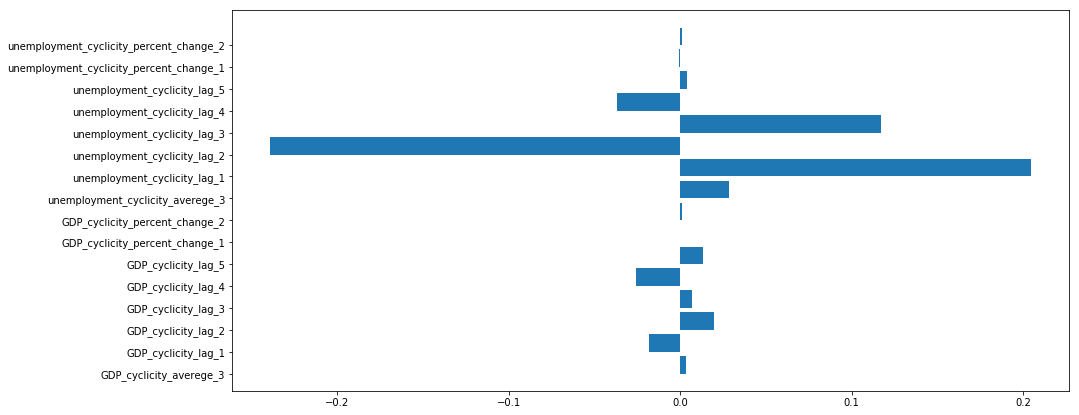

In [26]:
plt.barh(data_train.columns[1:],LinearRegression_model.coef_ , align = 'edge')

In [27]:
for i in range(len(data_train.columns[1:])):
    print(data_train.columns[1:][i], '---' ,LinearRegression_model.coef_[i])

unemployment_cyclicity_lag_1 --- 0.204646250650914
unemployment_cyclicity_lag_2 --- -0.23923143113541395
unemployment_cyclicity_lag_3 --- 0.11727681978693091
unemployment_cyclicity_lag_4 --- -0.036681947233352226
unemployment_cyclicity_lag_5 --- 0.003863666105869891
GDP_cyclicity_lag_1 --- -0.017945607421995156
GDP_cyclicity_lag_2 --- 0.019946834654850802
GDP_cyclicity_lag_3 --- 0.006971314696031652
GDP_cyclicity_lag_4 --- -0.02595687375178167
GDP_cyclicity_lag_5 --- 0.01318283538662706
unemployment_cyclicity_percent_change_1 --- -0.0008651306646225848
unemployment_cyclicity_percent_change_2 --- 0.0009853710914023636
GDP_cyclicity_percent_change_1 --- -2.1312314248581044e-05
GDP_cyclicity_percent_change_2 --- 0.000765495002048134
unemployment_cyclicity_averege_3 --- 0.028583802195043112
GDP_cyclicity_averege_3 --- 0.0031446009493465467


In [30]:
list_of_feature = []
for i in range(len(data_train.columns[1:])):
    if abs(LinearRegression_model.coef_[i]) > 0.011:
        list_of_feature.append(data_train.columns[1:][i])
list_of_feature

['unemployment_cyclicity_lag_1',
 'unemployment_cyclicity_lag_2',
 'unemployment_cyclicity_lag_3',
 'unemployment_cyclicity_lag_4',
 'GDP_cyclicity_lag_1',
 'GDP_cyclicity_lag_2',
 'GDP_cyclicity_lag_4',
 'GDP_cyclicity_lag_5',
 'unemployment_cyclicity_averege_3']

# Подбираем коэффициент регуляризации по валидации

In [42]:
def quality_control(model, data , target, columns_for_scaling , start_date= 60):
    predict = []
    for i in range(start_date, len(data)):
        #делим на обучение и тест
        X_train = data.iloc[:i]
        Y_train = target.iloc[:i]
        X_test = data.iloc[i:i+1]
        Y_test = target.values[i]
        X_train, X_test = scaling_for_DataFrame(X_train, X_test, columns_for_scaling)

        model.fit(X_train, Y_train)
        predict.append(model.predict(X_test))
        #print (i , 'Предсказание сделано')
        #print (i, model.coef_)
    #print (len(predict))
    #print (len(target[start_date:]))
    #metrics.mean_absolute_error(Y_test.values, predict)
    #print(target.iloc[start_date:])
    #print(predict)
    return  metrics.mean_absolute_error(target.iloc[start_date:], predict)

In [91]:
alpha = [0.1,0.07,0.06, 0.05,0.01 ,0.005,0.001, 0.001, 0.0005 ]

In [92]:
%%time
warnings.filterwarnings('ignore')
quality_control_for_1_lag = []
from sklearn.linear_model import Lasso
for i in alpha:
    print (i)
    model = Lasso(alpha = i)
    quality_control_for_1_lag.append(quality_control(model, data_train[list_of_feature],
                                            data_train['unemployment_cyclicity'],list_of_feature, start_date = 64))
warnings.filterwarnings('default')

0.1
0.07
0.06
0.05
0.01
0.005
0.001
0.001
0.0005
CPU times: user 1min 15s, sys: 28 ms, total: 1min 15s
Wall time: 1min 15s


In [93]:
quality_control_for_1_lag = list(map(lambda x: round(x, 5),quality_control_for_1_lag))

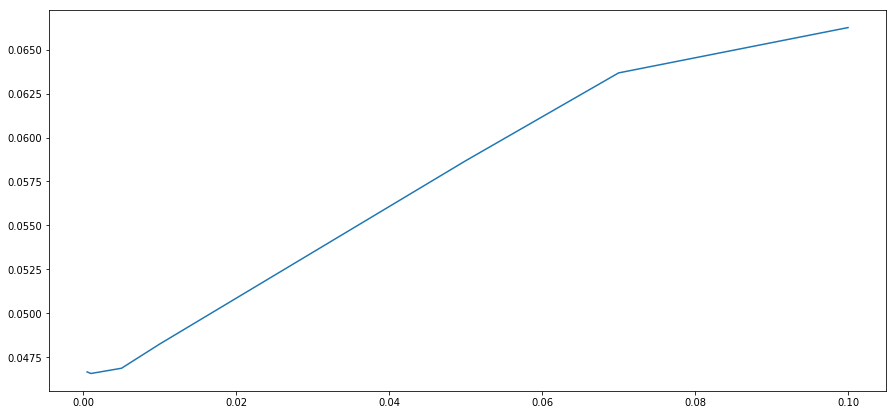

In [96]:
plt.plot(alpha[::-1], quality_control_for_1_lag[::-1])

In [106]:
val_score = pd.DataFrame()
val_score['alpha'] =alpha
val_score['mae'] = quality_control_for_1_lag
val_score

,alpha,mae
0,0.1000,0.06626
1,0.0700,0.06368
2,0.0600,0.06118
3,0.0500,0.05868
4,0.0100,0.04825
5,0.0050,0.04687
6,0.0010,0.04657
7,0.0010,0.04657
8,0.0005,0.04666


По Валидации отпределяем alpha = 0.001

## Обучаем линейную модель, тестим

In [223]:
X_train, X_test = scaling_for_DataFrame(data_train[list_of_feature], data_test[list_of_feature],
                                        list_of_feature)


from sklearn.linear_model import Lasso
model = Lasso(alpha =0.005)


model.fit(X_train, data_train['unemployment_cyclicity'].values)
predict = model.predict(X_test)
metrics.mean_absolute_error(data_test['unemployment_cyclicity'], predict)

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.009452076735176842

In [224]:
print('Ошибка составляет ',  mean_absolute_percentage_error(data_test['unemployment_cyclicity'].values, predict),'%')

Ошибка составляет  57.77909972441662 %


<Container object of 9 artists>

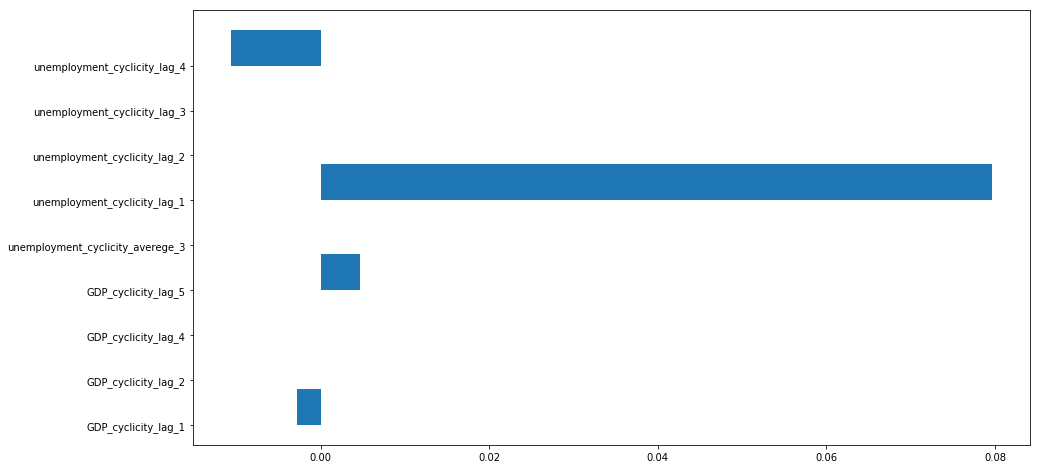

In [225]:
plt.barh(list_of_feature,model.coef_ , align = 'edge')

In [226]:
for i in range(len(list_of_feature)):
    print(list_of_feature[i], '---' ,model.coef_ [i])

unemployment_cyclicity_lag_1 --- 0.07957561224507205
unemployment_cyclicity_lag_2 --- -0.0
unemployment_cyclicity_lag_3 --- -0.0
unemployment_cyclicity_lag_4 --- -0.010675889373915073
GDP_cyclicity_lag_1 --- -0.0027802915252803
GDP_cyclicity_lag_2 --- -0.0
GDP_cyclicity_lag_4 --- 0.0
GDP_cyclicity_lag_5 --- 0.0047060236158975735
unemployment_cyclicity_averege_3 --- 0.0


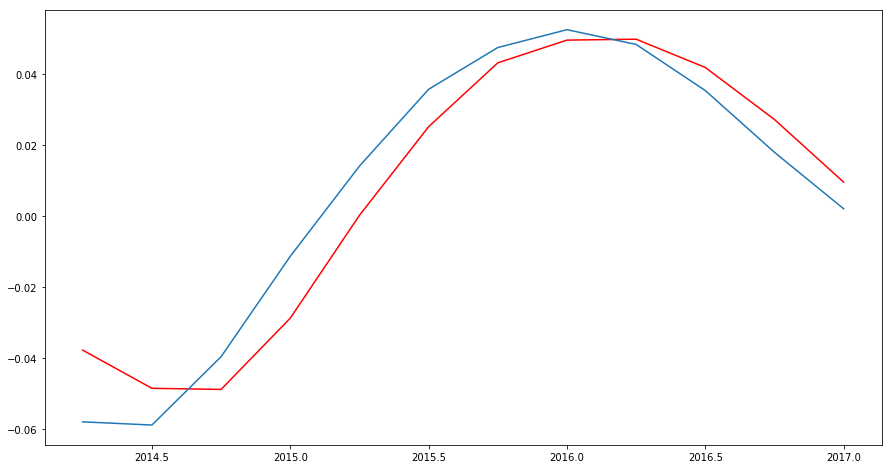

In [227]:
plt.plot(data_test['unemployment_cyclicity'].index, predict, color = 'r')
plt.plot(data_test['unemployment_cyclicity'].index, data_test['unemployment_cyclicity'].values)

In [228]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print (metrics.r2_score(data_train['unemployment_cyclicity'], pred_train))
metrics.mean_absolute_error(data_train['unemployment_cyclicity'], pred_train)

0.9421534878219529


0.01495094998770328

In [229]:
all_pred = np.hstack((np.array(pred_train), np.array(pred_test)))

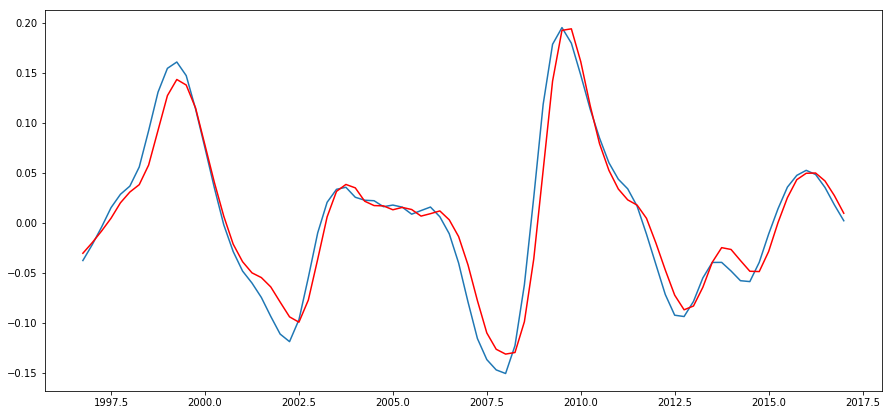

In [230]:
#Красное это предсказание,синее- истинная безработица.
plt.figure(figsize(15,7))
plt.plot(pd.concat([data_train['unemployment_cyclicity'], data_test['unemployment_cyclicity']], axis =0).index , pd.concat([data_train['unemployment_cyclicity'], data_test['unemployment_cyclicity']], axis =0).values)
predict = pd.DataFrame(predict)
predict.index = data_test['unemployment_cyclicity'].index
plt.plot(data.index, all_pred, color ='r')

# Рассмотрим остатки этой модели

In [231]:
pred_train

array([-0.03043035, -0.01976412, -0.00810546,  0.00462618,  0.02002443,
        0.03077918,  0.03814331,  0.05776481,  0.09246726,  0.12717572,
        0.14330983,  0.13777804,  0.11474152,  0.07761494,  0.04033208,
        0.00659681, -0.02127911, -0.0388597 , -0.05000049, -0.05474394,
       -0.06406918, -0.07921841, -0.09400545, -0.09933956, -0.07720966,
       -0.03631555,  0.00593668,  0.03146737,  0.03837453,  0.03495058,
        0.02161239,  0.01724925,  0.01694049,  0.01305129,  0.01540866,
        0.01331094,  0.00672358,  0.0091444 ,  0.01189545,  0.0030286 ,
       -0.01377801, -0.042155  , -0.07778064, -0.11009181, -0.12641661,
       -0.13124117, -0.12964469, -0.09887694, -0.03598227,  0.05263328,
        0.14163396,  0.19241917,  0.19396384,  0.16115274,  0.11736635,
        0.07909107,  0.05243777,  0.03380869,  0.02294785,  0.01770833,
        0.00446604, -0.02019052, -0.04717454, -0.07231999, -0.08694928,
       -0.08317057, -0.06438476, -0.03943497, -0.02481319, -0.02

In [232]:
data_train['unemployment_cyclicity'].head()

1996.75   -0.037704
1997.00   -0.021787
1997.25   -0.004108
1997.50    0.015189
1997.75    0.028531
Name: unemployment_cyclicity, dtype: float64

In [233]:
remnants =pd.DataFrame()
remnants['remnants'] = data_train['unemployment_cyclicity'].values - pred_train
remnants.index = data_train.index
remnants.head()

,remnants
1996.75,-0.007273
1997.00,-0.002023
1997.25,0.003998
1997.50,0.010563
1997.75,0.008506


Критерий Стьюдента: p=1.000000
Критерий Дики-Фуллера: p=0.002844


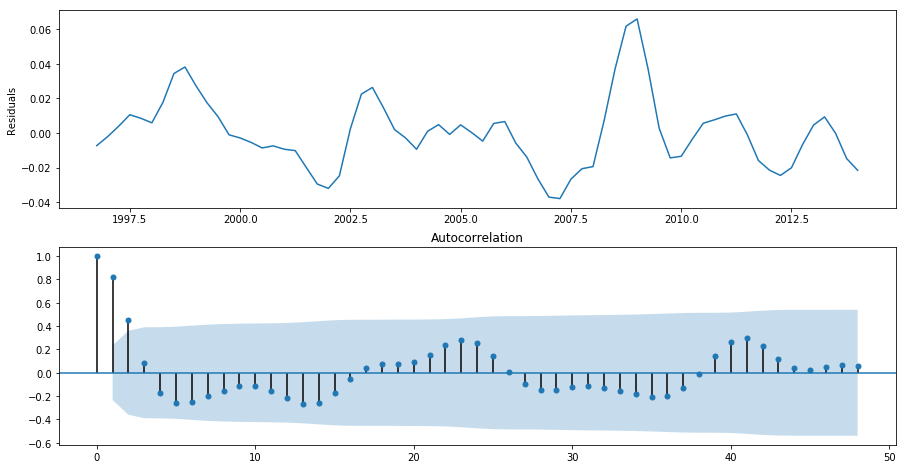

In [234]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(remnants.index, remnants)
#best_model.resid[5:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(remnants, lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(remnants, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(remnants["remnants"].values)[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой).